<a href="https://colab.research.google.com/github/rebornndisillusioned/icml2026/blob/main/ICML_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
!git clone https://github.com/Andrew-Draganov/Fast-Coreset-Generation.git
%cd Fast-Coreset-Generation

!pip -q install numpy scipy pandas scikit-learn matplotlib tqdm
!pip -q install NearPy==1.0.0 python-mnist

Cloning into 'Fast-Coreset-Generation'...
remote: Enumerating objects: 1332, done.
remote: Counting objects: 100% (365/365), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 1332 (delta 242), reused 220 (delta 113), pack-reused 967 (from 1)
Receiving objects: 100% (1332/1332), 3.15 MiB | 30.98 MiB/s, done.
Resolving deltas: 100% (925/925), done.
/content/Fast-Coreset-Generation
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.3/340.3 kB 25.5 MB/s eta 0:00:00


In [ ]:
import os, time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import make_coreset as mc

RESULTS_DIR = "/content/drive/MyDrive/coreset_experiments"
os.makedirs(RESULTS_DIR, exist_ok=True)

RUNS_CSV = os.path.join(RESULTS_DIR, "runs_fullgrid.csv")
print("Logging to:", RUNS_CSV)


Logging to: /content/drive/MyDrive/coreset_experiments/runs_fullgrid.csv


In [ ]:
from sklearn.datasets import fetch_covtype, fetch_openml
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def load_covtype_full(scale=True):
    X, _ = fetch_covtype(return_X_y=True)
    X = X.astype(np.float32)
    if scale:
        X = StandardScaler().fit_transform(X).astype(np.float32)
    return X

def load_mnist_full(center=True):
    X, _ = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    X = (X.astype(np.float32) / 255.0)
    if center:
        X = (X - X.mean(axis=0, keepdims=True)).astype(np.float32)
    return X

def load_adult_full():
    X_df, _ = fetch_openml("adult", version=2, return_X_y=True, as_frame=True)
    cat_cols = X_df.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = [c for c in X_df.columns if c not in cat_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop",
        sparse_threshold=0.0,  # dense output
    )
    X = pre.fit_transform(X_df).astype(np.float32)
    return X


In [ ]:
from sklearn.cluster import KMeans

def append_row(row: dict, csv_path: str):
    df = pd.DataFrame([row])
    header = not os.path.exists(csv_path)
    df.to_csv(csv_path, mode="a", index=False, header=header)

def load_done(csv_path):
    done = set()
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        for r in df.itertuples(index=False):
            done.add((r.dataset, r.algorithm, int(r.k), int(r.m), int(r.trial)))
    return done

def kmeans_cost_full(X, centers, batch=50000):
    X = np.asarray(X, dtype=np.float32)
    C = np.asarray(centers, dtype=np.float32)
    total = 0.0
    n = X.shape[0]
    for i in range(0, n, batch):
        Xi = X[i:i+batch]
        d2 = ((Xi[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)
        total += d2.min(axis=1).sum()
    return float(total)

def lloyd_steps(X, k, init_centers=None, sample_weight=None, iters=10, seed=0):
    if init_centers is None:
        init = "k-means++"
        n_init = 1
    else:
        init = np.asarray(init_centers, dtype=np.float32)
        n_init = 1

    km = KMeans(
        n_clusters=k,
        init=init,
        n_init=n_init,
        max_iter=iters,
        random_state=seed,
        algorithm="lloyd",
    )
    km.fit(X, sample_weight=sample_weight)
    return km.cluster_centers_


In [ ]:
import numpy as np

def choose_repo_kmeans_alg():
    for name in ["cluster_pp", "cluster_pp_fast", "fast_cluster_pp", "cluster_pp_slow"]:
        if hasattr(mc, name):
            return getattr(mc, name)
    return mc.cluster_pp_slow

REPO_KMEANS_ALG = choose_repo_kmeans_alg()
print("Using repo kmeans_alg:", REPO_KMEANS_ALG.__name__)

def call_repo_kmeans_alg(kmeans_alg, points, k, weights, allotted_time=np.inf, seed=None):
    # Try progressively “simpler” call signatures.
    try:
        return kmeans_alg(points, k, weights, allotted_time=allotted_time, seed=seed)
    except TypeError:
        try:
            return kmeans_alg(points, k, weights, allotted_time=allotted_time)
        except TypeError:
            return kmeans_alg(points, k, weights)

def can_reuse_sensitivities():
    return all(hasattr(mc, x) for x in ["bound_sensitivities", "get_coreset"])

REUSE_SENS = can_reuse_sensitivities()
print("Reuse sensitivities:", REUSE_SENS)

def compute_sensitivities_once(X, k, seed=0):
    X64 = np.asarray(X, dtype=np.float64)
    weights = np.ones(len(X64), dtype=np.float64)

    centers, labels, costs = call_repo_kmeans_alg(REPO_KMEANS_ALG, X64, k, weights, allotted_time=np.inf, seed=seed)
    costs = costs * weights
    sens = mc.bound_sensitivities(centers, labels, costs)
    return sens, labels, weights

def sample_coreset_from_sens(sens, m, X, labels, weights, seed=0):
    X64 = np.asarray(X, dtype=np.float64)
    r_points, r_weights, _ = mc.get_coreset(sens, m, X64, labels, weights=weights)
    return np.asarray(r_points, dtype=np.float32), np.asarray(r_weights, dtype=np.float32)

def make_sensitivity_coreset(X, k, m, seed=0):
    X64 = np.asarray(X, dtype=np.float64)
    C, w, _ = mc.sensitivity_coreset(
        points=X64, k=k, m=m, norm=2,
        kmeans_alg=REPO_KMEANS_ALG,
        allotted_time=np.inf,
        weights=None,
        seed=seed,   # harmless; sensitivity_coreset has **kwargs
    )
    return np.asarray(C, dtype=np.float32), np.asarray(w, dtype=np.float32)


Using repo kmeans_alg: cluster_pp
Reuse sensitivities: True


In [ ]:
def dist2_to_centers(X, centers):
    return ((X[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)

def d2_sample_point(X, centers, weights=None, rng=None):
    rng = rng or np.random.default_rng()
    n = X.shape[0]

    if centers is None or len(centers) == 0:
        if weights is None:
            return X[rng.integers(n)]
        p = weights / (weights.sum() + 1e-12)
        return X[rng.choice(n, p=p)]

    d2 = dist2_to_centers(X, centers).min(axis=1)
    if weights is not None:
        d2 = d2 * weights
    probs = d2 / (d2.sum() + 1e-12)
    return X[rng.choice(n, p=probs)]

def best_single_swap(centers, cand, X_eval, w_eval=None, try_centers="all", rng=None):
    rng = rng or np.random.default_rng()
    k = centers.shape[0]

    d2_all = dist2_to_centers(X_eval, centers)  # (neval, k)
    idx1 = np.argmin(d2_all, axis=1)
    d1 = d2_all[np.arange(d2_all.shape[0]), idx1]
    part = np.partition(d2_all, kth=1, axis=1)
    d2_second = part[:, 1]

    cand_d2 = ((X_eval - cand) ** 2).sum(axis=1)

    base_cost = float(d1.sum()) if w_eval is None else float((w_eval * d1).sum())

    if try_centers == "all" or (isinstance(try_centers, int) and try_centers >= k):
        J = np.arange(k)
    else:
        t = int(try_centers)
        J = rng.choice(k, size=t, replace=False)

    best_cost = base_cost
    best_j = None

    for j in J:
        fallback = np.where(idx1 == j, d2_second, d1)
        new_d = np.minimum(fallback, cand_d2)
        new_cost = float(new_d.sum()) if w_eval is None else float((w_eval * new_d).sum())
        if new_cost < best_cost:
            best_cost = new_cost
            best_j = int(j)

    return best_j

def kmeanspp_seed(X, k, seed=0, weights=None):
    rng = np.random.default_rng(seed)
    centers = []
    centers.append(d2_sample_point(X, centers=None, weights=weights, rng=rng))
    while len(centers) < k:
        centers.append(d2_sample_point(X, np.asarray(centers), weights=weights, rng=rng))
    return np.asarray(centers, dtype=np.float32)

def localsearch_seed(X, k, seed=0, weights=None, params=None):
    params = params or {}
    rng = np.random.default_rng(seed)

    iters = int(params.get("iters", 30))
    eval_n = int(params.get("eval_n", 20000))
    try_centers = params.get("try_centers", "all")

    centers = kmeanspp_seed(X, k, seed=seed, weights=weights)

    n = X.shape[0]
    eval_n_eff = min(eval_n, n)
    idx = rng.choice(n, size=eval_n_eff, replace=False)
    X_eval = X[idx]
    w_eval = None if weights is None else weights[idx]

    for _ in range(iters):
        if weights is None:
            cand = X[rng.integers(n)]
        else:
            p = weights / (weights.sum() + 1e-12)
            cand = X[rng.choice(n, p=p)]
        j = best_single_swap(centers, cand, X_eval, w_eval=w_eval, try_centers=try_centers, rng=rng)
        if j is not None:
            centers[j] = cand

    return centers

def localsearchpp_seed(X, k, seed=0, weights=None, params=None):
    params = params or {}
    rng = np.random.default_rng(seed)

    extra_rounds = int(params.get("extra_rounds", 50))
    eval_n = int(params.get("eval_n", 20000))
    try_centers = params.get("try_centers", "all")

    centers = kmeanspp_seed(X, k, seed=seed, weights=weights)

    n = X.shape[0]
    eval_n_eff = min(eval_n, n)
    idx = rng.choice(n, size=eval_n_eff, replace=False)
    X_eval = X[idx]
    w_eval = None if weights is None else weights[idx]

    for _ in range(extra_rounds):
        cand = d2_sample_point(X, centers, weights=weights, rng=rng)
        j = best_single_swap(centers, cand, X_eval, w_eval=w_eval, try_centers=try_centers, rng=rng)
        if j is not None:
            centers[j] = cand

    return centers


In [ ]:
def run_full_grid_for_dataset(dataset_name, X, k_list, m_mults, trials, algo_params, lloyd_iters=10):
    algorithms = ["kmeans", "localsearch", "localsearch_pp"]
    done = load_done(RUNS_CSV)

    n, d = int(X.shape[0]), int(X.shape[1])
    print(f"\n=== {dataset_name}: n={n}, d={d} ===")

    # run small k first, small m first (partial results come quickly)
    for k in sorted(k_list):
        for trial in trials:
            # ----- full-data baselines (once per algo for this k/trial) -----
            full_cost = {}
            for algo in algorithms:
                if algo == "kmeans":
                    init = kmeanspp_seed(X, k, seed=trial, weights=None)
                elif algo == "localsearch":
                    init = localsearch_seed(X, k, seed=trial, weights=None, params=algo_params["localsearch"])
                else:
                    init = localsearchpp_seed(X, k, seed=trial, weights=None, params=algo_params["localsearch_pp"])

                centers_full = lloyd_steps(X, k, init_centers=init, sample_weight=None, iters=lloyd_iters, seed=trial)
                full_cost[algo] = kmeans_cost_full(X, centers_full)

            # ----- coreset prep once per (k, trial), then sample all m -----
            if REUSE_SENS:
                sens, labels, weights_used = compute_sensitivities_once(X, k, seed=trial)
                coreset_sampler = lambda m: sample_coreset_from_sens(sens, m, X, labels, weights_used, seed=trial)
            else:
                coreset_sampler = lambda m: make_sensitivity_coreset(X, k, m, seed=trial)

            for mult in sorted(m_mults):
                m = int(mult * k)

                # sample coreset once per m (shared across algs)
                C, w = coreset_sampler(m)

                for algo in algorithms:
                    key = (dataset_name, algo, k, m, trial)
                    if key in done:
                        continue

                    t0 = time.time()

                    # initializer on coreset (weighted)
                    if algo == "kmeans":
                        init = kmeanspp_seed(C, k, seed=trial, weights=w)
                    elif algo == "localsearch":
                        init = localsearch_seed(C, k, seed=trial, weights=w, params=algo_params["localsearch"])
                    else:
                        init = localsearchpp_seed(C, k, seed=trial, weights=w, params=algo_params["localsearch_pp"])

                    # Lloyd steps on coreset (weighted)
                    centers_core = lloyd_steps(C, k, init_centers=init, sample_weight=w, iters=lloyd_iters, seed=trial)

                    # evaluate on full dataset
                    cost_full = full_cost[algo]
                    cost_core = kmeans_cost_full(X, centers_core)
                    ratio = cost_core / (cost_full + 1e-12)

                    row = dict(
                        dataset=dataset_name,
                        algorithm=algo,
                        k=int(k),
                        m=int(m),
                        m_over_k=float(m / k),
                        trial=int(trial),

                        cost_full=float(cost_full),
                        cost_core=float(cost_core),
                        ratio=float(ratio),

                        n=n, d=d,
                        lloyd_iters=int(lloyd_iters),

                        ls_iters=int(algo_params["localsearch"].get("iters", 0)),
                        ls_eval_n=int(algo_params["localsearch"].get("eval_n", 0)),
                        ls_try_centers=str(algo_params["localsearch"].get("try_centers", "all")),

                        lspp_extra_rounds=int(algo_params["localsearch_pp"].get("extra_rounds", 0)),
                        lspp_eval_n=int(algo_params["localsearch_pp"].get("eval_n", 0)),
                        lspp_try_centers=str(algo_params["localsearch_pp"].get("try_centers", "all")),

                        seconds=float(time.time() - t0),
                    )
                    append_row(row, RUNS_CSV)
                    done.add(key)
                    print("logged:", dataset_name, algo, "k=", k, "m=", m, "trial=", trial, "ratio=", ratio)


In [ ]:
def plot_dataset_m_over_k(csv_path, dataset_name):
    if not os.path.exists(csv_path):
        print("No CSV yet.")
        return

    df = pd.read_csv(csv_path)
    df = df[df["dataset"] == dataset_name].copy()
    if df.empty:
        print("No rows for", dataset_name)
        return

    # aggregate over all k and trials (so we get 3 curves total)
    agg = df.groupby(["algorithm", "m_over_k"], as_index=False)["ratio"].agg(["mean", "std", "count"])
    agg.columns = ["algorithm", "m_over_k", "mean", "std", "count"]
    agg["sem"] = agg["std"] / np.sqrt(np.maximum(1, agg["count"]))

    alg_order = ["kmeans", "localsearch", "localsearch_pp"]

    plt.figure(figsize=(7,4))
    for alg in alg_order:
        a = agg[agg["algorithm"] == alg].sort_values("m_over_k")
        if a.empty:
            continue
        plt.plot(a["m_over_k"], a["mean"], marker="o", linewidth=1.2, label=alg)
        if len(a) > 1:
            plt.fill_between(a["m_over_k"], a["mean"]-a["sem"], a["mean"]+a["sem"], alpha=0.0)

    plt.xscale("log")
    plt.xlabel("m/k")
    plt.ylabel("cost ratio")
    plt.title(dataset_name)
    plt.grid(True, which="both", linewidth=0.3, alpha=0.5)
    plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()


Loading Adult...
Adult: (48842, 108)
Loading MNIST...
MNIST: (70000, 784)
Loading Covertype...
Covertype: (581012, 54)

=== adult: n=48842, d=108 ===


  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 0 ratio= 2.172464095507448
logged: adult localsearch k= 2 m= 4 trial= 0 ratio= 2.1724840309807205
logged: adult localsearch_pp k= 2 m= 4 trial= 0 ratio= 2.172520678025754
logged: adult kmeans k= 2 m= 10 trial= 0 ratio= 1.2922493311385663
logged: adult localsearch k= 2 m= 10 trial= 0 ratio= 1.2922611893791953
logged: adult localsearch_pp k= 2 m= 10 trial= 0 ratio= 1.2922829881833877
logged: adult kmeans k= 2 m= 20 trial= 0 ratio= 1.1762353053578818
logged: adult localsearch k= 2 m= 20 trial= 0 ratio= 1.1762460990034662
logged: adult localsearch_pp k= 2 m= 20 trial= 0 ratio= 1.176265940780504
logged: adult kmeans k= 2 m= 100 trial= 0 ratio= 1.0528992272164055
logged: adult localsearch k= 2 m= 100 trial= 0 ratio= 1.0371737339152631
logged: adult localsearch_pp k= 2 m= 100 trial= 0 ratio= 1.054251182936511
logged: adult kmeans k= 2 m= 200 trial= 0 ratio= 1.0611441099844894
logged: adult localsearch k= 2 m= 200 trial= 0 ratio= 1.0220430088663244
logged:

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 1 ratio= 1.6649913518442818
logged: adult localsearch k= 2 m= 4 trial= 1 ratio= 1.7239354091453967
logged: adult localsearch_pp k= 2 m= 4 trial= 1 ratio= 1.7241387360616869
logged: adult kmeans k= 2 m= 10 trial= 1 ratio= 1.2149547523479005
logged: adult localsearch k= 2 m= 10 trial= 1 ratio= 1.2690839437154882
logged: adult localsearch_pp k= 2 m= 10 trial= 1 ratio= 1.2692336238737005
logged: adult kmeans k= 2 m= 20 trial= 1 ratio= 1.148288543933076
logged: adult localsearch k= 2 m= 20 trial= 1 ratio= 1.187650886414677
logged: adult localsearch_pp k= 2 m= 20 trial= 1 ratio= 1.187790962075913
logged: adult kmeans k= 2 m= 100 trial= 1 ratio= 1.0408231631749898
logged: adult localsearch k= 2 m= 100 trial= 1 ratio= 1.0553965995268786
logged: adult localsearch_pp k= 2 m= 100 trial= 1 ratio= 1.0635701783861178
logged: adult kmeans k= 2 m= 200 trial= 1 ratio= 1.0108538296578167
logged: adult localsearch k= 2 m= 200 trial= 1 ratio= 1.0140380699276392
logged

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 2 ratio= 1.5130422156433447
logged: adult localsearch k= 2 m= 4 trial= 2 ratio= 1.513092342943233
logged: adult localsearch_pp k= 2 m= 4 trial= 2 ratio= 1.5130194501660341
logged: adult kmeans k= 2 m= 10 trial= 2 ratio= 1.2254837498000282
logged: adult localsearch k= 2 m= 10 trial= 2 ratio= 1.2255243502477877
logged: adult localsearch_pp k= 2 m= 10 trial= 2 ratio= 1.225465310973793
logged: adult kmeans k= 2 m= 20 trial= 2 ratio= 1.1562812967395288
logged: adult localsearch k= 2 m= 20 trial= 2 ratio= 1.1654930770153618
logged: adult localsearch_pp k= 2 m= 20 trial= 2 ratio= 1.1654369297302432
logged: adult kmeans k= 2 m= 100 trial= 2 ratio= 1.0722166561083308
logged: adult localsearch k= 2 m= 100 trial= 2 ratio= 1.0377760513218925
logged: adult localsearch_pp k= 2 m= 100 trial= 2 ratio= 1.0377260567668052
logged: adult kmeans k= 2 m= 200 trial= 2 ratio= 1.0341093513434771
logged: adult localsearch k= 2 m= 200 trial= 2 ratio= 1.0122159124263124
logge

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 3 ratio= 1.4071034844761816
logged: adult localsearch k= 2 m= 4 trial= 3 ratio= 1.592288368969958
logged: adult localsearch_pp k= 2 m= 4 trial= 3 ratio= 1.592328334418724
logged: adult kmeans k= 2 m= 10 trial= 3 ratio= 1.2017468934146733
logged: adult localsearch k= 2 m= 10 trial= 3 ratio= 1.1684780496598985
logged: adult localsearch_pp k= 2 m= 10 trial= 3 ratio= 1.1685073777329646
logged: adult kmeans k= 2 m= 20 trial= 3 ratio= 1.2129126539798971
logged: adult localsearch k= 2 m= 20 trial= 3 ratio= 1.1849989636645684
logged: adult localsearch_pp k= 2 m= 20 trial= 3 ratio= 1.1850287064023117
logged: adult kmeans k= 2 m= 100 trial= 3 ratio= 1.0209536802021895
logged: adult localsearch k= 2 m= 100 trial= 3 ratio= 1.0188927457599308
logged: adult localsearch_pp k= 2 m= 100 trial= 3 ratio= 1.0212493229240183
logged: adult kmeans k= 2 m= 200 trial= 3 ratio= 1.016360562255174
logged: adult localsearch k= 2 m= 200 trial= 3 ratio= 1.021010486419148
logged:

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 4 ratio= 1.575344467938027
logged: adult localsearch k= 2 m= 4 trial= 4 ratio= 1.5759526856933572
logged: adult localsearch_pp k= 2 m= 4 trial= 4 ratio= 1.5758694292793658
logged: adult kmeans k= 2 m= 10 trial= 4 ratio= 1.2174586583504377
logged: adult localsearch k= 2 m= 10 trial= 4 ratio= 1.2262088266770685
logged: adult localsearch_pp k= 2 m= 10 trial= 4 ratio= 1.2261440469722964
logged: adult kmeans k= 2 m= 20 trial= 4 ratio= 1.111224258614995
logged: adult localsearch k= 2 m= 20 trial= 4 ratio= 1.1483032106300515
logged: adult localsearch_pp k= 2 m= 20 trial= 4 ratio= 1.1496621221358512
logged: adult kmeans k= 2 m= 100 trial= 4 ratio= 1.0318276254359575
logged: adult localsearch k= 2 m= 100 trial= 4 ratio= 1.0263848525449362
logged: adult localsearch_pp k= 2 m= 100 trial= 4 ratio= 1.0210652456877696
logged: adult kmeans k= 2 m= 200 trial= 4 ratio= 1.022607640181405
logged: adult localsearch k= 2 m= 200 trial= 4 ratio= 1.0164226709820263
logged

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 5 ratio= 1.3279583031780426
logged: adult localsearch k= 2 m= 4 trial= 5 ratio= 1.5538140277540868
logged: adult localsearch_pp k= 2 m= 4 trial= 5 ratio= 1.5536825662801748
logged: adult kmeans k= 2 m= 10 trial= 5 ratio= 1.2393837295433772
logged: adult localsearch k= 2 m= 10 trial= 5 ratio= 1.2450495423620123
logged: adult localsearch_pp k= 2 m= 10 trial= 5 ratio= 1.2449442041136707
logged: adult kmeans k= 2 m= 20 trial= 5 ratio= 1.1135315487878754
logged: adult localsearch k= 2 m= 20 trial= 5 ratio= 1.142825102183146
logged: adult localsearch_pp k= 2 m= 20 trial= 5 ratio= 1.142728412701861
logged: adult kmeans k= 2 m= 100 trial= 5 ratio= 1.0309668239397494
logged: adult localsearch k= 2 m= 100 trial= 5 ratio= 1.0290541149633263
logged: adult localsearch_pp k= 2 m= 100 trial= 5 ratio= 1.020689121937548
logged: adult kmeans k= 2 m= 200 trial= 5 ratio= 1.0491853651960332
logged: adult localsearch k= 2 m= 200 trial= 5 ratio= 1.0332568894003744
logged

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 6 ratio= 1.527017949916057
logged: adult localsearch k= 2 m= 4 trial= 6 ratio= 1.5320127356123023
logged: adult localsearch_pp k= 2 m= 4 trial= 6 ratio= 1.5165604359566742
logged: adult kmeans k= 2 m= 10 trial= 6 ratio= 1.1418663963701503
logged: adult localsearch k= 2 m= 10 trial= 6 ratio= 1.145601374039487
logged: adult localsearch_pp k= 2 m= 10 trial= 6 ratio= 1.1340465251103216
logged: adult kmeans k= 2 m= 20 trial= 6 ratio= 1.1604071825488735
logged: adult localsearch k= 2 m= 20 trial= 6 ratio= 1.1816072972097853
logged: adult localsearch_pp k= 2 m= 20 trial= 6 ratio= 1.169689282687233
logged: adult kmeans k= 2 m= 100 trial= 6 ratio= 1.0349047142908254
logged: adult localsearch k= 2 m= 100 trial= 6 ratio= 1.0354432800172888
logged: adult localsearch_pp k= 2 m= 100 trial= 6 ratio= 1.0249995157669616
logged: adult kmeans k= 2 m= 200 trial= 6 ratio= 1.029093863747206
logged: adult localsearch k= 2 m= 200 trial= 6 ratio= 1.0324599691102905
logged:

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 7 ratio= 1.410101718278715
logged: adult localsearch k= 2 m= 4 trial= 7 ratio= 1.459043715268111
logged: adult localsearch_pp k= 2 m= 4 trial= 7 ratio= 1.4588653476566047
logged: adult kmeans k= 2 m= 10 trial= 7 ratio= 1.3129533814385528
logged: adult localsearch k= 2 m= 10 trial= 7 ratio= 1.4423790211192555
logged: adult localsearch_pp k= 2 m= 10 trial= 7 ratio= 1.4422026907610959
logged: adult kmeans k= 2 m= 20 trial= 7 ratio= 1.1726049329843506
logged: adult localsearch k= 2 m= 20 trial= 7 ratio= 1.1406646309922988
logged: adult localsearch_pp k= 2 m= 20 trial= 7 ratio= 1.140525185118518
logged: adult kmeans k= 2 m= 100 trial= 7 ratio= 1.0140881691546397
logged: adult localsearch k= 2 m= 100 trial= 7 ratio= 1.01704275631407
logged: adult localsearch_pp k= 2 m= 100 trial= 7 ratio= 1.0169184231735717
logged: adult kmeans k= 2 m= 200 trial= 7 ratio= 1.0302885989334598
logged: adult localsearch k= 2 m= 200 trial= 7 ratio= 1.0231474852692055
logged: 

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 8 ratio= 1.3783805558671534
logged: adult localsearch k= 2 m= 4 trial= 8 ratio= 1.4903582795005963
logged: adult localsearch_pp k= 2 m= 4 trial= 8 ratio= 1.490511032928648
logged: adult kmeans k= 2 m= 10 trial= 8 ratio= 1.1661396853014703
logged: adult localsearch k= 2 m= 10 trial= 8 ratio= 1.170173249791726
logged: adult localsearch_pp k= 2 m= 10 trial= 8 ratio= 1.170293186036439
logged: adult kmeans k= 2 m= 20 trial= 8 ratio= 1.136113314712787
logged: adult localsearch k= 2 m= 20 trial= 8 ratio= 1.1105369807087326
logged: adult localsearch_pp k= 2 m= 20 trial= 8 ratio= 1.1106508045678105
logged: adult kmeans k= 2 m= 100 trial= 8 ratio= 1.0280312255961763
logged: adult localsearch k= 2 m= 100 trial= 8 ratio= 1.0290439052219982
logged: adult localsearch_pp k= 2 m= 100 trial= 8 ratio= 1.029712454868543
logged: adult kmeans k= 2 m= 200 trial= 8 ratio= 1.012623476791165
logged: adult localsearch k= 2 m= 200 trial= 8 ratio= 1.0142186163711433
logged: a

  0%|          | 0/4 [00:00<?, ?it/s]

logged: adult kmeans k= 2 m= 4 trial= 9 ratio= 1.4605638022294496
logged: adult localsearch k= 2 m= 4 trial= 9 ratio= 1.4621769247076735
logged: adult localsearch_pp k= 2 m= 4 trial= 9 ratio= 1.4544191334485013
logged: adult kmeans k= 2 m= 10 trial= 9 ratio= 1.1677167569964741
logged: adult localsearch k= 2 m= 10 trial= 9 ratio= 1.2273060401219196
logged: adult localsearch_pp k= 2 m= 10 trial= 9 ratio= 1.2207943903280407
logged: adult kmeans k= 2 m= 20 trial= 9 ratio= 1.1327593068682666
logged: adult localsearch k= 2 m= 20 trial= 9 ratio= 1.2172912812600238
logged: adult localsearch_pp k= 2 m= 20 trial= 9 ratio= 1.2108327662184781
logged: adult kmeans k= 2 m= 100 trial= 9 ratio= 1.0571665522590203
logged: adult localsearch k= 2 m= 100 trial= 9 ratio= 1.0298220232662925
logged: adult localsearch_pp k= 2 m= 100 trial= 9 ratio= 1.0243581535008772
logged: adult kmeans k= 2 m= 200 trial= 9 ratio= 1.0166952264546874
logged: adult localsearch k= 2 m= 200 trial= 9 ratio= 1.027461037184856
logg

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 0 ratio= 1.4742092421868922
logged: adult localsearch k= 5 m= 10 trial= 0 ratio= 1.5338957209381687
logged: adult localsearch_pp k= 5 m= 10 trial= 0 ratio= 1.6359330701174273
logged: adult kmeans k= 5 m= 25 trial= 0 ratio= 1.3050800244972691
logged: adult localsearch k= 5 m= 25 trial= 0 ratio= 1.3252551565571202
logged: adult localsearch_pp k= 5 m= 25 trial= 0 ratio= 1.4134133809496654
logged: adult kmeans k= 5 m= 50 trial= 0 ratio= 1.1128887106559489
logged: adult localsearch k= 5 m= 50 trial= 0 ratio= 1.1352841206168525
logged: adult localsearch_pp k= 5 m= 50 trial= 0 ratio= 1.1788081737286238
logged: adult kmeans k= 5 m= 250 trial= 0 ratio= 1.1368918789829494
logged: adult localsearch k= 5 m= 250 trial= 0 ratio= 1.060474067917299
logged: adult localsearch_pp k= 5 m= 250 trial= 0 ratio= 1.112284763251175
logged: adult kmeans k= 5 m= 500 trial= 0 ratio= 1.1439239905581964
logged: adult localsearch k= 5 m= 500 trial= 0 ratio= 1.043040981314845
log

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 1 ratio= 1.6316756859075419
logged: adult localsearch k= 5 m= 10 trial= 1 ratio= 1.6703614866542846
logged: adult localsearch_pp k= 5 m= 10 trial= 1 ratio= 1.757330568716378
logged: adult kmeans k= 5 m= 25 trial= 1 ratio= 1.2118329103394552
logged: adult localsearch k= 5 m= 25 trial= 1 ratio= 1.2721751706880466
logged: adult localsearch_pp k= 5 m= 25 trial= 1 ratio= 1.3384122742736526
logged: adult kmeans k= 5 m= 50 trial= 1 ratio= 1.1323318814343255
logged: adult localsearch k= 5 m= 50 trial= 1 ratio= 1.1862524449772422
logged: adult localsearch_pp k= 5 m= 50 trial= 1 ratio= 1.290547295691673
logged: adult kmeans k= 5 m= 250 trial= 1 ratio= 1.037039524907754
logged: adult localsearch k= 5 m= 250 trial= 1 ratio= 1.0358478686083
logged: adult localsearch_pp k= 5 m= 250 trial= 1 ratio= 1.094998575449711
logged: adult kmeans k= 5 m= 500 trial= 1 ratio= 0.9995845738984421
logged: adult localsearch k= 5 m= 500 trial= 1 ratio= 1.0156096740176759
logged:

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 2 ratio= 1.5187368028499428
logged: adult localsearch k= 5 m= 10 trial= 2 ratio= 1.7597255777243264
logged: adult localsearch_pp k= 5 m= 10 trial= 2 ratio= 1.8788268592936654
logged: adult kmeans k= 5 m= 25 trial= 2 ratio= 1.252769923029219
logged: adult localsearch k= 5 m= 25 trial= 2 ratio= 1.2528693714048116
logged: adult localsearch_pp k= 5 m= 25 trial= 2 ratio= 1.3376657451475031
logged: adult kmeans k= 5 m= 50 trial= 2 ratio= 1.0614912785362642
logged: adult localsearch k= 5 m= 50 trial= 2 ratio= 1.1589024156489496
logged: adult localsearch_pp k= 5 m= 50 trial= 2 ratio= 1.239943404634943
logged: adult kmeans k= 5 m= 250 trial= 2 ratio= 1.0403816364164575
logged: adult localsearch k= 5 m= 250 trial= 2 ratio= 1.0467027603663368
logged: adult localsearch_pp k= 5 m= 250 trial= 2 ratio= 1.032438520817882
logged: adult kmeans k= 5 m= 500 trial= 2 ratio= 0.9497040637906768
logged: adult localsearch k= 5 m= 500 trial= 2 ratio= 1.0358785364134033
log

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 3 ratio= 1.426101396730539
logged: adult localsearch k= 5 m= 10 trial= 3 ratio= 1.701031684727884
logged: adult localsearch_pp k= 5 m= 10 trial= 3 ratio= 1.589281097525007
logged: adult kmeans k= 5 m= 25 trial= 3 ratio= 1.3167342719440018
logged: adult localsearch k= 5 m= 25 trial= 3 ratio= 1.4378164260689081
logged: adult localsearch_pp k= 5 m= 25 trial= 3 ratio= 1.3433579680955952
logged: adult kmeans k= 5 m= 50 trial= 3 ratio= 1.1540026347610493
logged: adult localsearch k= 5 m= 50 trial= 3 ratio= 1.2819324931262508
logged: adult localsearch_pp k= 5 m= 50 trial= 3 ratio= 1.1878938542307464
logged: adult kmeans k= 5 m= 250 trial= 3 ratio= 1.0898684405810632
logged: adult localsearch k= 5 m= 250 trial= 3 ratio= 1.1238362609979085
logged: adult localsearch_pp k= 5 m= 250 trial= 3 ratio= 0.9766069758231016
logged: adult kmeans k= 5 m= 500 trial= 3 ratio= 1.1072958106097297
logged: adult localsearch k= 5 m= 500 trial= 3 ratio= 1.098053252480268
logg

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 4 ratio= 1.3181993954743167
logged: adult localsearch k= 5 m= 10 trial= 4 ratio= 1.478553800757018
logged: adult localsearch_pp k= 5 m= 10 trial= 4 ratio= 1.470794419146148
logged: adult kmeans k= 5 m= 25 trial= 4 ratio= 1.26548672938909
logged: adult localsearch k= 5 m= 25 trial= 4 ratio= 1.212407097707209
logged: adult localsearch_pp k= 5 m= 25 trial= 4 ratio= 1.2060444416212275
logged: adult kmeans k= 5 m= 50 trial= 4 ratio= 1.2757896480975526
logged: adult localsearch k= 5 m= 50 trial= 4 ratio= 1.2973456023918062
logged: adult localsearch_pp k= 5 m= 50 trial= 4 ratio= 1.2905371929818894
logged: adult kmeans k= 5 m= 250 trial= 4 ratio= 1.070059459927757
logged: adult localsearch k= 5 m= 250 trial= 4 ratio= 1.0395676594584053
logged: adult localsearch_pp k= 5 m= 250 trial= 4 ratio= 1.04863643109015
logged: adult kmeans k= 5 m= 500 trial= 4 ratio= 1.0356438789564493
logged: adult localsearch k= 5 m= 500 trial= 4 ratio= 1.134628389926894
logged: a

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 5 ratio= 1.4260421241353842
logged: adult localsearch k= 5 m= 10 trial= 5 ratio= 1.581554190768725
logged: adult localsearch_pp k= 5 m= 10 trial= 5 ratio= 1.6904329295739127
logged: adult kmeans k= 5 m= 25 trial= 5 ratio= 1.4299051355438221
logged: adult localsearch k= 5 m= 25 trial= 5 ratio= 1.5441747656207105
logged: adult localsearch_pp k= 5 m= 25 trial= 5 ratio= 1.650480197301088
logged: adult kmeans k= 5 m= 50 trial= 5 ratio= 1.084606499965066
logged: adult localsearch k= 5 m= 50 trial= 5 ratio= 1.3016374634995498
logged: adult localsearch_pp k= 5 m= 50 trial= 5 ratio= 1.3912459298009987
logged: adult kmeans k= 5 m= 250 trial= 5 ratio= 0.9867173697960854
logged: adult localsearch k= 5 m= 250 trial= 5 ratio= 1.052751213537865
logged: adult localsearch_pp k= 5 m= 250 trial= 5 ratio= 1.0554984465356516
logged: adult kmeans k= 5 m= 500 trial= 5 ratio= 0.9625066436934194
logged: adult localsearch k= 5 m= 500 trial= 5 ratio= 1.0525134069366098
logg

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 6 ratio= 1.398132543977124
logged: adult localsearch k= 5 m= 10 trial= 6 ratio= 1.4457043478494833
logged: adult localsearch_pp k= 5 m= 10 trial= 6 ratio= 1.4523402595458768
logged: adult kmeans k= 5 m= 25 trial= 6 ratio= 1.347105097798847
logged: adult localsearch k= 5 m= 25 trial= 6 ratio= 1.3768607071124248
logged: adult localsearch_pp k= 5 m= 25 trial= 6 ratio= 1.2316254111627465
logged: adult kmeans k= 5 m= 50 trial= 6 ratio= 1.1866686494457719
logged: adult localsearch k= 5 m= 50 trial= 6 ratio= 1.2102572131198266
logged: adult localsearch_pp k= 5 m= 50 trial= 6 ratio= 1.1335337333788553
logged: adult kmeans k= 5 m= 250 trial= 6 ratio= 1.1032645105564545
logged: adult localsearch k= 5 m= 250 trial= 6 ratio= 1.0632323433777324
logged: adult localsearch_pp k= 5 m= 250 trial= 6 ratio= 0.9953431822623998
logged: adult kmeans k= 5 m= 500 trial= 6 ratio= 1.0195191134764376
logged: adult localsearch k= 5 m= 500 trial= 6 ratio= 1.102066637698044
log

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 7 ratio= 1.5173410817906487
logged: adult localsearch k= 5 m= 10 trial= 7 ratio= 1.6164913991083836
logged: adult localsearch_pp k= 5 m= 10 trial= 7 ratio= 1.7261053378010958
logged: adult kmeans k= 5 m= 25 trial= 7 ratio= 1.2013599895158957
logged: adult localsearch k= 5 m= 25 trial= 7 ratio= 1.1918372470119176
logged: adult localsearch_pp k= 5 m= 25 trial= 7 ratio= 1.2726554777786967
logged: adult kmeans k= 5 m= 50 trial= 7 ratio= 1.1388537334564555
logged: adult localsearch k= 5 m= 50 trial= 7 ratio= 1.2120219813468207
logged: adult localsearch_pp k= 5 m= 50 trial= 7 ratio= 1.305440695162707
logged: adult kmeans k= 5 m= 250 trial= 7 ratio= 1.0465677091946368
logged: adult localsearch k= 5 m= 250 trial= 7 ratio= 1.0392461424145238
logged: adult localsearch_pp k= 5 m= 250 trial= 7 ratio= 1.03838756843407
logged: adult kmeans k= 5 m= 500 trial= 7 ratio= 1.068876712015352
logged: adult localsearch k= 5 m= 500 trial= 7 ratio= 1.0186592608278422
logg

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 8 ratio= 1.576174358523515
logged: adult localsearch k= 5 m= 10 trial= 8 ratio= 1.732297703098772
logged: adult localsearch_pp k= 5 m= 10 trial= 8 ratio= 1.6518572434886214
logged: adult kmeans k= 5 m= 25 trial= 8 ratio= 1.3989605303644856
logged: adult localsearch k= 5 m= 25 trial= 8 ratio= 1.4030055649162712
logged: adult localsearch_pp k= 5 m= 25 trial= 8 ratio= 1.4745099949220402
logged: adult kmeans k= 5 m= 50 trial= 8 ratio= 1.1190190334994385
logged: adult localsearch k= 5 m= 50 trial= 8 ratio= 1.2839729377793314
logged: adult localsearch_pp k= 5 m= 50 trial= 8 ratio= 1.3947095416036432
logged: adult kmeans k= 5 m= 250 trial= 8 ratio= 1.0950166837833626
logged: adult localsearch k= 5 m= 250 trial= 8 ratio= 1.04655993283624
logged: adult localsearch_pp k= 5 m= 250 trial= 8 ratio= 1.045831608360324
logged: adult kmeans k= 5 m= 500 trial= 8 ratio= 1.0210401090140384
logged: adult localsearch k= 5 m= 500 trial= 8 ratio= 1.0178995554368586
logge

  0%|          | 0/10 [00:00<?, ?it/s]

logged: adult kmeans k= 5 m= 10 trial= 9 ratio= 1.658289740920832
logged: adult localsearch k= 5 m= 10 trial= 9 ratio= 1.5890426335394963
logged: adult localsearch_pp k= 5 m= 10 trial= 9 ratio= 1.5745693567411698
logged: adult kmeans k= 5 m= 25 trial= 9 ratio= 1.4538521743079158
logged: adult localsearch k= 5 m= 25 trial= 9 ratio= 1.404805442371769
logged: adult localsearch_pp k= 5 m= 25 trial= 9 ratio= 1.386451577935091
logged: adult kmeans k= 5 m= 50 trial= 9 ratio= 1.3261184959749548
logged: adult localsearch k= 5 m= 50 trial= 9 ratio= 1.1678127582937747
logged: adult localsearch_pp k= 5 m= 50 trial= 9 ratio= 1.1571761164928216
logged: adult kmeans k= 5 m= 250 trial= 9 ratio= 1.04520373646706
logged: adult localsearch k= 5 m= 250 trial= 9 ratio= 1.0856251157004664
logged: adult localsearch_pp k= 5 m= 250 trial= 9 ratio= 1.018508536949014
logged: adult kmeans k= 5 m= 500 trial= 9 ratio= 1.1735490293323882
logged: adult localsearch k= 5 m= 500 trial= 9 ratio= 1.1667794495659995
logged

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 0 ratio= 1.4536212977186012
logged: adult localsearch k= 10 m= 20 trial= 0 ratio= 1.492374719665167
logged: adult localsearch_pp k= 10 m= 20 trial= 0 ratio= 1.5162691783663407
logged: adult kmeans k= 10 m= 50 trial= 0 ratio= 1.321485397067498
logged: adult localsearch k= 10 m= 50 trial= 0 ratio= 1.3048203977005304
logged: adult localsearch_pp k= 10 m= 50 trial= 0 ratio= 1.3212851639290002
logged: adult kmeans k= 10 m= 100 trial= 0 ratio= 1.2872544934692913
logged: adult localsearch k= 10 m= 100 trial= 0 ratio= 1.2726429939954644
logged: adult localsearch_pp k= 10 m= 100 trial= 0 ratio= 1.1476265037478222
logged: adult kmeans k= 10 m= 500 trial= 0 ratio= 1.1997070545333048
logged: adult localsearch k= 10 m= 500 trial= 0 ratio= 1.0515253153861415
logged: adult localsearch_pp k= 10 m= 500 trial= 0 ratio= 1.059725285226723
logged: adult kmeans k= 10 m= 1000 trial= 0 ratio= 1.1615572763525681
logged: adult localsearch k= 10 m= 1000 trial= 0 ratio= 1.0

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 1 ratio= 1.6476070466413346
logged: adult localsearch k= 10 m= 20 trial= 1 ratio= 1.7080105342576286
logged: adult localsearch_pp k= 10 m= 20 trial= 1 ratio= 1.7192607255560897
logged: adult kmeans k= 10 m= 50 trial= 1 ratio= 1.3811600873891923
logged: adult localsearch k= 10 m= 50 trial= 1 ratio= 1.4000500071516777
logged: adult localsearch_pp k= 10 m= 50 trial= 1 ratio= 1.4141704379685185
logged: adult kmeans k= 10 m= 100 trial= 1 ratio= 1.1674050032469236
logged: adult localsearch k= 10 m= 100 trial= 1 ratio= 1.1292145492423042
logged: adult localsearch_pp k= 10 m= 100 trial= 1 ratio= 1.1401518602701752
logged: adult kmeans k= 10 m= 500 trial= 1 ratio= 1.1633132912130033
logged: adult localsearch k= 10 m= 500 trial= 1 ratio= 1.1573171490682619
logged: adult localsearch_pp k= 10 m= 500 trial= 1 ratio= 1.0453926738800314
logged: adult kmeans k= 10 m= 1000 trial= 1 ratio= 1.0168177795050168
logged: adult localsearch k= 10 m= 1000 trial= 1 ratio= 

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 2 ratio= 1.7415152674335213
logged: adult localsearch k= 10 m= 20 trial= 2 ratio= 1.7168104526325765
logged: adult localsearch_pp k= 10 m= 20 trial= 2 ratio= 1.9287079436902637
logged: adult kmeans k= 10 m= 50 trial= 2 ratio= 1.4886219558578473
logged: adult localsearch k= 10 m= 50 trial= 2 ratio= 1.316390357343143
logged: adult localsearch_pp k= 10 m= 50 trial= 2 ratio= 1.4719232295441342
logged: adult kmeans k= 10 m= 100 trial= 2 ratio= 1.16018781400482
logged: adult localsearch k= 10 m= 100 trial= 2 ratio= 1.0337950096547739
logged: adult localsearch_pp k= 10 m= 100 trial= 2 ratio= 1.1469773252766196
logged: adult kmeans k= 10 m= 500 trial= 2 ratio= 1.1877083660037229
logged: adult localsearch k= 10 m= 500 trial= 2 ratio= 0.9301143504271248
logged: adult localsearch_pp k= 10 m= 500 trial= 2 ratio= 1.0517298963373278
logged: adult kmeans k= 10 m= 1000 trial= 2 ratio= 1.154540511611193
logged: adult localsearch k= 10 m= 1000 trial= 2 ratio= 0.89

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 3 ratio= 1.6612231910497393
logged: adult localsearch k= 10 m= 20 trial= 3 ratio= 1.7083797184742882
logged: adult localsearch_pp k= 10 m= 20 trial= 3 ratio= 1.704422063644207
logged: adult kmeans k= 10 m= 50 trial= 3 ratio= 1.3943506142831197
logged: adult localsearch k= 10 m= 50 trial= 3 ratio= 1.4256908396067112
logged: adult localsearch_pp k= 10 m= 50 trial= 3 ratio= 1.2957087106330802
logged: adult kmeans k= 10 m= 100 trial= 3 ratio= 1.319641944849721
logged: adult localsearch k= 10 m= 100 trial= 3 ratio= 1.3183106921178727
logged: adult localsearch_pp k= 10 m= 100 trial= 3 ratio= 1.1874817900626782
logged: adult kmeans k= 10 m= 500 trial= 3 ratio= 1.0856206113532907
logged: adult localsearch k= 10 m= 500 trial= 3 ratio= 1.0676538390218908
logged: adult localsearch_pp k= 10 m= 500 trial= 3 ratio= 1.0530174369329623
logged: adult kmeans k= 10 m= 1000 trial= 3 ratio= 1.0470682034184846
logged: adult localsearch k= 10 m= 1000 trial= 3 ratio= 1.

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 4 ratio= 1.726759068932731
logged: adult localsearch k= 10 m= 20 trial= 4 ratio= 1.7291861876334225
logged: adult localsearch_pp k= 10 m= 20 trial= 4 ratio= 1.7606261271230452
logged: adult kmeans k= 10 m= 50 trial= 4 ratio= 1.5036437291158835
logged: adult localsearch k= 10 m= 50 trial= 4 ratio= 1.5194828610250384
logged: adult localsearch_pp k= 10 m= 50 trial= 4 ratio= 1.3734797671141925
logged: adult kmeans k= 10 m= 100 trial= 4 ratio= 1.3339853962646837
logged: adult localsearch k= 10 m= 100 trial= 4 ratio= 1.207342342288034
logged: adult localsearch_pp k= 10 m= 100 trial= 4 ratio= 1.2090556598832942
logged: adult kmeans k= 10 m= 500 trial= 4 ratio= 1.074713203291899
logged: adult localsearch k= 10 m= 500 trial= 4 ratio= 1.1842304310174658
logged: adult localsearch_pp k= 10 m= 500 trial= 4 ratio= 1.051049607657096
logged: adult kmeans k= 10 m= 1000 trial= 4 ratio= 1.0313914811907863
logged: adult localsearch k= 10 m= 1000 trial= 4 ratio= 1.02

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 5 ratio= 1.4745581046900613
logged: adult localsearch k= 10 m= 20 trial= 5 ratio= 1.6403135895753485
logged: adult localsearch_pp k= 10 m= 20 trial= 5 ratio= 1.64212513593782
logged: adult kmeans k= 10 m= 50 trial= 5 ratio= 1.2650470052386802
logged: adult localsearch k= 10 m= 50 trial= 5 ratio= 1.5806708853965274
logged: adult localsearch_pp k= 10 m= 50 trial= 5 ratio= 1.4365015074472047
logged: adult kmeans k= 10 m= 100 trial= 5 ratio= 1.1040531355759835
logged: adult localsearch k= 10 m= 100 trial= 5 ratio= 1.1916477254678157
logged: adult localsearch_pp k= 10 m= 100 trial= 5 ratio= 1.1926270024132972
logged: adult kmeans k= 10 m= 500 trial= 5 ratio= 0.9446114674746235
logged: adult localsearch k= 10 m= 500 trial= 5 ratio= 1.051684881253745
logged: adult localsearch_pp k= 10 m= 500 trial= 5 ratio= 1.0612297825905064
logged: adult kmeans k= 10 m= 1000 trial= 5 ratio= 1.0230147260048026
logged: adult localsearch k= 10 m= 1000 trial= 5 ratio= 1.0

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 6 ratio= 1.7390109463979855
logged: adult localsearch k= 10 m= 20 trial= 6 ratio= 1.7307685853250379
logged: adult localsearch_pp k= 10 m= 20 trial= 6 ratio= 1.7826418243560427
logged: adult kmeans k= 10 m= 50 trial= 6 ratio= 1.346668410429686
logged: adult localsearch k= 10 m= 50 trial= 6 ratio= 1.4756663798126302
logged: adult localsearch_pp k= 10 m= 50 trial= 6 ratio= 1.3786749974606818
logged: adult kmeans k= 10 m= 100 trial= 6 ratio= 1.2769863440407607
logged: adult localsearch k= 10 m= 100 trial= 6 ratio= 1.1622877334465784
logged: adult localsearch_pp k= 10 m= 100 trial= 6 ratio= 1.2110601173302293
logged: adult kmeans k= 10 m= 500 trial= 6 ratio= 1.2104254151406084
logged: adult localsearch k= 10 m= 500 trial= 6 ratio= 1.1631103500150126
logged: adult localsearch_pp k= 10 m= 500 trial= 6 ratio= 1.080549371209896
logged: adult kmeans k= 10 m= 1000 trial= 6 ratio= 1.0055530919531852
logged: adult localsearch k= 10 m= 1000 trial= 6 ratio= 1.

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 7 ratio= 1.7609110346694072
logged: adult localsearch k= 10 m= 20 trial= 7 ratio= 1.8397610809718967
logged: adult localsearch_pp k= 10 m= 20 trial= 7 ratio= 1.837791856788016
logged: adult kmeans k= 10 m= 50 trial= 7 ratio= 1.4970404910731796
logged: adult localsearch k= 10 m= 50 trial= 7 ratio= 1.5032849832809698
logged: adult localsearch_pp k= 10 m= 50 trial= 7 ratio= 1.373091838186215
logged: adult kmeans k= 10 m= 100 trial= 7 ratio= 1.1818275782986318
logged: adult localsearch k= 10 m= 100 trial= 7 ratio= 1.19300440634024
logged: adult localsearch_pp k= 10 m= 100 trial= 7 ratio= 1.1987760014881441
logged: adult kmeans k= 10 m= 500 trial= 7 ratio= 1.0412294617248026
logged: adult localsearch k= 10 m= 500 trial= 7 ratio= 1.1604312705783844
logged: adult localsearch_pp k= 10 m= 500 trial= 7 ratio= 1.0452552276532188
logged: adult kmeans k= 10 m= 1000 trial= 7 ratio= 1.0120848572111922
logged: adult localsearch k= 10 m= 1000 trial= 7 ratio= 1.02

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 8 ratio= 1.4822144764460183
logged: adult localsearch k= 10 m= 20 trial= 8 ratio= 1.671155448033754
logged: adult localsearch_pp k= 10 m= 20 trial= 8 ratio= 1.7111683739568286
logged: adult kmeans k= 10 m= 50 trial= 8 ratio= 1.2514638801971154
logged: adult localsearch k= 10 m= 50 trial= 8 ratio= 1.3493179556415904
logged: adult localsearch_pp k= 10 m= 50 trial= 8 ratio= 1.368479835854628
logged: adult kmeans k= 10 m= 100 trial= 8 ratio= 1.0357167635565094
logged: adult localsearch k= 10 m= 100 trial= 8 ratio= 1.150549567036827
logged: adult localsearch_pp k= 10 m= 100 trial= 8 ratio= 1.1658085277554304
logged: adult kmeans k= 10 m= 500 trial= 8 ratio= 0.9089730217784248
logged: adult localsearch k= 10 m= 500 trial= 8 ratio= 1.0322786651526608
logged: adult localsearch_pp k= 10 m= 500 trial= 8 ratio= 1.0401231090290914
logged: adult kmeans k= 10 m= 1000 trial= 8 ratio= 1.022749159183238
logged: adult localsearch k= 10 m= 1000 trial= 8 ratio= 1.00

  0%|          | 0/20 [00:00<?, ?it/s]

logged: adult kmeans k= 10 m= 20 trial= 9 ratio= 1.6196743191551655
logged: adult localsearch k= 10 m= 20 trial= 9 ratio= 1.5843693327842183
logged: adult localsearch_pp k= 10 m= 20 trial= 9 ratio= 1.6036686114679906
logged: adult kmeans k= 10 m= 50 trial= 9 ratio= 1.4798755393545937
logged: adult localsearch k= 10 m= 50 trial= 9 ratio= 1.6026042951849395
logged: adult localsearch_pp k= 10 m= 50 trial= 9 ratio= 1.6354647645373843
logged: adult kmeans k= 10 m= 100 trial= 9 ratio= 1.187375232639635
logged: adult localsearch k= 10 m= 100 trial= 9 ratio= 1.1849182382770214
logged: adult localsearch_pp k= 10 m= 100 trial= 9 ratio= 1.17774363575882
logged: adult kmeans k= 10 m= 500 trial= 9 ratio= 1.2066432236279103
logged: adult localsearch k= 10 m= 500 trial= 9 ratio= 1.0383508094714957
logged: adult localsearch_pp k= 10 m= 500 trial= 9 ratio= 1.0695862368850901
logged: adult kmeans k= 10 m= 1000 trial= 9 ratio= 1.0520006330640135
logged: adult localsearch k= 10 m= 1000 trial= 9 ratio= 1.0

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 0 ratio= 1.5602472984361133
logged: adult localsearch k= 50 m= 100 trial= 0 ratio= 1.5817037325270726
logged: adult localsearch_pp k= 50 m= 100 trial= 0 ratio= 1.5942958470129143
logged: adult kmeans k= 50 m= 250 trial= 0 ratio= 1.3145817292615314
logged: adult localsearch k= 50 m= 250 trial= 0 ratio= 1.2989390662711644
logged: adult localsearch_pp k= 50 m= 250 trial= 0 ratio= 1.286329816946317
logged: adult kmeans k= 50 m= 500 trial= 0 ratio= 1.1798897927812306
logged: adult localsearch k= 50 m= 500 trial= 0 ratio= 1.1872853224459698
logged: adult localsearch_pp k= 50 m= 500 trial= 0 ratio= 1.196185400761297
logged: adult kmeans k= 50 m= 2500 trial= 0 ratio= 1.0513855150178786
logged: adult localsearch k= 50 m= 2500 trial= 0 ratio= 1.0447868741404385
logged: adult localsearch_pp k= 50 m= 2500 trial= 0 ratio= 1.0339898776766312
logged: adult kmeans k= 50 m= 5000 trial= 0 ratio= 1.017480700855176
logged: adult localsearch k= 50 m= 5000 trial= 0 r

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 1 ratio= 1.6859488185325682
logged: adult localsearch k= 50 m= 100 trial= 1 ratio= 1.7037149799208593
logged: adult localsearch_pp k= 50 m= 100 trial= 1 ratio= 1.7177994242831993
logged: adult kmeans k= 50 m= 250 trial= 1 ratio= 1.2731011160629215
logged: adult localsearch k= 50 m= 250 trial= 1 ratio= 1.3089784304016787
logged: adult localsearch_pp k= 50 m= 250 trial= 1 ratio= 1.3134060917361425
logged: adult kmeans k= 50 m= 500 trial= 1 ratio= 1.2049614399975512
logged: adult localsearch k= 50 m= 500 trial= 1 ratio= 1.2066106803331034
logged: adult localsearch_pp k= 50 m= 500 trial= 1 ratio= 1.22078144627818
logged: adult kmeans k= 50 m= 2500 trial= 1 ratio= 1.0355542308270558
logged: adult localsearch k= 50 m= 2500 trial= 1 ratio= 1.0467865987974905
logged: adult localsearch_pp k= 50 m= 2500 trial= 1 ratio= 1.0603010194784108
logged: adult kmeans k= 50 m= 5000 trial= 1 ratio= 1.018028027760681
logged: adult localsearch k= 50 m= 5000 trial= 1 r

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 2 ratio= 1.5460026922465933
logged: adult localsearch k= 50 m= 100 trial= 2 ratio= 1.5565296219384925
logged: adult localsearch_pp k= 50 m= 100 trial= 2 ratio= 1.56723267719236
logged: adult kmeans k= 50 m= 250 trial= 2 ratio= 1.2998897387363826
logged: adult localsearch k= 50 m= 250 trial= 2 ratio= 1.297732736211393
logged: adult localsearch_pp k= 50 m= 250 trial= 2 ratio= 1.3024016775299658
logged: adult kmeans k= 50 m= 500 trial= 2 ratio= 1.184014554910821
logged: adult localsearch k= 50 m= 500 trial= 2 ratio= 1.174346934567901
logged: adult localsearch_pp k= 50 m= 500 trial= 2 ratio= 1.1758859665896546
logged: adult kmeans k= 50 m= 2500 trial= 2 ratio= 1.046677798294123
logged: adult localsearch k= 50 m= 2500 trial= 2 ratio= 1.0334636159561394
logged: adult localsearch_pp k= 50 m= 2500 trial= 2 ratio= 1.0526854619817738
logged: adult kmeans k= 50 m= 5000 trial= 2 ratio= 1.0152014709982287
logged: adult localsearch k= 50 m= 5000 trial= 2 rati

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 3 ratio= 1.4957802926706159
logged: adult localsearch k= 50 m= 100 trial= 3 ratio= 1.5068549131110234
logged: adult localsearch_pp k= 50 m= 100 trial= 3 ratio= 1.4977620992150482
logged: adult kmeans k= 50 m= 250 trial= 3 ratio= 1.3182365087398698
logged: adult localsearch k= 50 m= 250 trial= 3 ratio= 1.2964197598485445
logged: adult localsearch_pp k= 50 m= 250 trial= 3 ratio= 1.2970798634614784
logged: adult kmeans k= 50 m= 500 trial= 3 ratio= 1.2028669808834922
logged: adult localsearch k= 50 m= 500 trial= 3 ratio= 1.1992546100529953
logged: adult localsearch_pp k= 50 m= 500 trial= 3 ratio= 1.18660320452834
logged: adult kmeans k= 50 m= 2500 trial= 3 ratio= 1.05341327894508
logged: adult localsearch k= 50 m= 2500 trial= 3 ratio= 1.047368269665342
logged: adult localsearch_pp k= 50 m= 2500 trial= 3 ratio= 1.0462981476842437
logged: adult kmeans k= 50 m= 5000 trial= 3 ratio= 1.0286839819675082
logged: adult localsearch k= 50 m= 5000 trial= 3 rat

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 4 ratio= 1.4632817762797041
logged: adult localsearch k= 50 m= 100 trial= 4 ratio= 1.4705787126206613
logged: adult localsearch_pp k= 50 m= 100 trial= 4 ratio= 1.4785064182064431
logged: adult kmeans k= 50 m= 250 trial= 4 ratio= 1.2806615772072523
logged: adult localsearch k= 50 m= 250 trial= 4 ratio= 1.2946631916376434
logged: adult localsearch_pp k= 50 m= 250 trial= 4 ratio= 1.2783782769054761
logged: adult kmeans k= 50 m= 500 trial= 4 ratio= 1.184211077147871
logged: adult localsearch k= 50 m= 500 trial= 4 ratio= 1.2081712538917193
logged: adult localsearch_pp k= 50 m= 500 trial= 4 ratio= 1.1958932666599718
logged: adult kmeans k= 50 m= 2500 trial= 4 ratio= 1.0316821436858872
logged: adult localsearch k= 50 m= 2500 trial= 4 ratio= 1.0631267002837843
logged: adult localsearch_pp k= 50 m= 2500 trial= 4 ratio= 1.045681778569512
logged: adult kmeans k= 50 m= 5000 trial= 4 ratio= 1.0137183130735516
logged: adult localsearch k= 50 m= 5000 trial= 4 

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 5 ratio= 1.5135019497052258
logged: adult localsearch k= 50 m= 100 trial= 5 ratio= 1.499227942148946
logged: adult localsearch_pp k= 50 m= 100 trial= 5 ratio= 1.4943383999653619
logged: adult kmeans k= 50 m= 250 trial= 5 ratio= 1.3261490651484031
logged: adult localsearch k= 50 m= 250 trial= 5 ratio= 1.3045342019563895
logged: adult localsearch_pp k= 50 m= 250 trial= 5 ratio= 1.2897032424431023
logged: adult kmeans k= 50 m= 500 trial= 5 ratio= 1.228554466724021
logged: adult localsearch k= 50 m= 500 trial= 5 ratio= 1.2199591976714264
logged: adult localsearch_pp k= 50 m= 500 trial= 5 ratio= 1.2149348903630706
logged: adult kmeans k= 50 m= 2500 trial= 5 ratio= 1.0675854964334213
logged: adult localsearch k= 50 m= 2500 trial= 5 ratio= 1.0637053608902205
logged: adult localsearch_pp k= 50 m= 2500 trial= 5 ratio= 1.0566787019817903
logged: adult kmeans k= 50 m= 5000 trial= 5 ratio= 1.0402870218279454
logged: adult localsearch k= 50 m= 5000 trial= 5 

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 6 ratio= 1.532408842401631
logged: adult localsearch k= 50 m= 100 trial= 6 ratio= 1.5391336537750813
logged: adult localsearch_pp k= 50 m= 100 trial= 6 ratio= 1.5375981558159786
logged: adult kmeans k= 50 m= 250 trial= 6 ratio= 1.3175057714501213
logged: adult localsearch k= 50 m= 250 trial= 6 ratio= 1.3174232573684326
logged: adult localsearch_pp k= 50 m= 250 trial= 6 ratio= 1.318084199719925
logged: adult kmeans k= 50 m= 500 trial= 6 ratio= 1.2038263946593306
logged: adult localsearch k= 50 m= 500 trial= 6 ratio= 1.2010404162454222
logged: adult localsearch_pp k= 50 m= 500 trial= 6 ratio= 1.2047116007668697
logged: adult kmeans k= 50 m= 2500 trial= 6 ratio= 1.0530418994950048
logged: adult localsearch k= 50 m= 2500 trial= 6 ratio= 1.0531989813334006
logged: adult localsearch_pp k= 50 m= 2500 trial= 6 ratio= 1.0479095989893832
logged: adult kmeans k= 50 m= 5000 trial= 6 ratio= 1.0231854138766219
logged: adult localsearch k= 50 m= 5000 trial= 6 

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 7 ratio= 1.4873453706040354
logged: adult localsearch k= 50 m= 100 trial= 7 ratio= 1.4991837743047505
logged: adult localsearch_pp k= 50 m= 100 trial= 7 ratio= 1.5034803836001323
logged: adult kmeans k= 50 m= 250 trial= 7 ratio= 1.2984764692377642
logged: adult localsearch k= 50 m= 250 trial= 7 ratio= 1.3020940049661385
logged: adult localsearch_pp k= 50 m= 250 trial= 7 ratio= 1.2982341570232314
logged: adult kmeans k= 50 m= 500 trial= 7 ratio= 1.1990183801954488
logged: adult localsearch k= 50 m= 500 trial= 7 ratio= 1.195955814638189
logged: adult localsearch_pp k= 50 m= 500 trial= 7 ratio= 1.1926301069895557
logged: adult kmeans k= 50 m= 2500 trial= 7 ratio= 1.0399402702091936
logged: adult localsearch k= 50 m= 2500 trial= 7 ratio= 1.0597469464989908
logged: adult localsearch_pp k= 50 m= 2500 trial= 7 ratio= 1.0455072030557797
logged: adult kmeans k= 50 m= 5000 trial= 7 ratio= 1.0092191698790898
logged: adult localsearch k= 50 m= 5000 trial= 7

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 8 ratio= 1.5479260097947107
logged: adult localsearch k= 50 m= 100 trial= 8 ratio= 1.557696808226106
logged: adult localsearch_pp k= 50 m= 100 trial= 8 ratio= 1.562175864811819
logged: adult kmeans k= 50 m= 250 trial= 8 ratio= 1.3086976937559343
logged: adult localsearch k= 50 m= 250 trial= 8 ratio= 1.2970052349273966
logged: adult localsearch_pp k= 50 m= 250 trial= 8 ratio= 1.2859097387978304
logged: adult kmeans k= 50 m= 500 trial= 8 ratio= 1.2000432757555175
logged: adult localsearch k= 50 m= 500 trial= 8 ratio= 1.1930109737743024
logged: adult localsearch_pp k= 50 m= 500 trial= 8 ratio= 1.175343578382889
logged: adult kmeans k= 50 m= 2500 trial= 8 ratio= 1.0436828166757826
logged: adult localsearch k= 50 m= 2500 trial= 8 ratio= 1.0416127946926153
logged: adult localsearch_pp k= 50 m= 2500 trial= 8 ratio= 1.0308125281190728
logged: adult kmeans k= 50 m= 5000 trial= 8 ratio= 1.021109363336245
logged: adult localsearch k= 50 m= 5000 trial= 8 ra

  0%|          | 0/100 [00:00<?, ?it/s]

logged: adult kmeans k= 50 m= 100 trial= 9 ratio= 1.562441153038314
logged: adult localsearch k= 50 m= 100 trial= 9 ratio= 1.5811396103697128
logged: adult localsearch_pp k= 50 m= 100 trial= 9 ratio= 1.5844007505417719
logged: adult kmeans k= 50 m= 250 trial= 9 ratio= 1.3246846406412207
logged: adult localsearch k= 50 m= 250 trial= 9 ratio= 1.3128656893236894
logged: adult localsearch_pp k= 50 m= 250 trial= 9 ratio= 1.3056159894531632
logged: adult kmeans k= 50 m= 500 trial= 9 ratio= 1.1882666702880182
logged: adult localsearch k= 50 m= 500 trial= 9 ratio= 1.1800866021623226
logged: adult localsearch_pp k= 50 m= 500 trial= 9 ratio= 1.1850695884606488
logged: adult kmeans k= 50 m= 2500 trial= 9 ratio= 1.0416917143477946
logged: adult localsearch k= 50 m= 2500 trial= 9 ratio= 1.0416284614251459
logged: adult localsearch_pp k= 50 m= 2500 trial= 9 ratio= 1.0470825690421937
logged: adult kmeans k= 50 m= 5000 trial= 9 ratio= 1.0162683180029453
logged: adult localsearch k= 50 m= 5000 trial= 9

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 0 ratio= 1.6742855951117614
logged: adult localsearch k= 100 m= 200 trial= 0 ratio= 1.6808992004558896
logged: adult localsearch_pp k= 100 m= 200 trial= 0 ratio= 1.6838711744155954
logged: adult kmeans k= 100 m= 500 trial= 0 ratio= 1.3015360249199164
logged: adult localsearch k= 100 m= 500 trial= 0 ratio= 1.3066930111991772
logged: adult localsearch_pp k= 100 m= 500 trial= 0 ratio= 1.29147925302684
logged: adult kmeans k= 100 m= 1000 trial= 0 ratio= 1.1870737452747497
logged: adult localsearch k= 100 m= 1000 trial= 0 ratio= 1.183075708244582
logged: adult localsearch_pp k= 100 m= 1000 trial= 0 ratio= 1.1812385790574258
logged: adult kmeans k= 100 m= 5000 trial= 0 ratio= 1.0436729392508672
logged: adult localsearch k= 100 m= 5000 trial= 0 ratio= 1.0420195872670603
logged: adult localsearch_pp k= 100 m= 5000 trial= 0 ratio= 1.0415432567508194
logged: adult kmeans k= 100 m= 10000 trial= 0 ratio= 1.0191728143345595
logged: adult localsearch k= 100 

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 1 ratio= 1.4934766027876996
logged: adult localsearch k= 100 m= 200 trial= 1 ratio= 1.511965505663522
logged: adult localsearch_pp k= 100 m= 200 trial= 1 ratio= 1.5060859759523357
logged: adult kmeans k= 100 m= 500 trial= 1 ratio= 1.2852449522263898
logged: adult localsearch k= 100 m= 500 trial= 1 ratio= 1.2904655204507853
logged: adult localsearch_pp k= 100 m= 500 trial= 1 ratio= 1.3052417802880765
logged: adult kmeans k= 100 m= 1000 trial= 1 ratio= 1.1881837486548255
logged: adult localsearch k= 100 m= 1000 trial= 1 ratio= 1.2040071744322995
logged: adult localsearch_pp k= 100 m= 1000 trial= 1 ratio= 1.1977126701152112
logged: adult kmeans k= 100 m= 5000 trial= 1 ratio= 1.0342507414066828
logged: adult localsearch k= 100 m= 5000 trial= 1 ratio= 1.0472064249789934
logged: adult localsearch_pp k= 100 m= 5000 trial= 1 ratio= 1.0472923912212055
logged: adult kmeans k= 100 m= 10000 trial= 1 ratio= 1.0164232278783034
logged: adult localsearch k= 10

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 2 ratio= 1.5559949625822433
logged: adult localsearch k= 100 m= 200 trial= 2 ratio= 1.577790777059301
logged: adult localsearch_pp k= 100 m= 200 trial= 2 ratio= 1.5610069372239097
logged: adult kmeans k= 100 m= 500 trial= 2 ratio= 1.311686162929499
logged: adult localsearch k= 100 m= 500 trial= 2 ratio= 1.3184304856717892
logged: adult localsearch_pp k= 100 m= 500 trial= 2 ratio= 1.3242985555643532
logged: adult kmeans k= 100 m= 1000 trial= 2 ratio= 1.2015025854090449
logged: adult localsearch k= 100 m= 1000 trial= 2 ratio= 1.1965904891478487
logged: adult localsearch_pp k= 100 m= 1000 trial= 2 ratio= 1.1959026613428787
logged: adult kmeans k= 100 m= 5000 trial= 2 ratio= 1.0332408746914685
logged: adult localsearch k= 100 m= 5000 trial= 2 ratio= 1.0609039555826731
logged: adult localsearch_pp k= 100 m= 5000 trial= 2 ratio= 1.0480035360438942
logged: adult kmeans k= 100 m= 10000 trial= 2 ratio= 1.022367624361251
logged: adult localsearch k= 100 

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 3 ratio= 1.5078975763447349
logged: adult localsearch k= 100 m= 200 trial= 3 ratio= 1.5235009168018279
logged: adult localsearch_pp k= 100 m= 200 trial= 3 ratio= 1.5392252359085195
logged: adult kmeans k= 100 m= 500 trial= 3 ratio= 1.300622793334417
logged: adult localsearch k= 100 m= 500 trial= 3 ratio= 1.30545035586651
logged: adult localsearch_pp k= 100 m= 500 trial= 3 ratio= 1.317177722098286
logged: adult kmeans k= 100 m= 1000 trial= 3 ratio= 1.1804224879917493
logged: adult localsearch k= 100 m= 1000 trial= 3 ratio= 1.1945656242015423
logged: adult localsearch_pp k= 100 m= 1000 trial= 3 ratio= 1.1890756141793757
logged: adult kmeans k= 100 m= 5000 trial= 3 ratio= 1.0501237485881918
logged: adult localsearch k= 100 m= 5000 trial= 3 ratio= 1.0506093121357876
logged: adult localsearch_pp k= 100 m= 5000 trial= 3 ratio= 1.0442337819956635
logged: adult kmeans k= 100 m= 10000 trial= 3 ratio= 1.0209934742893287
logged: adult localsearch k= 100 m

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 4 ratio= 1.6887975937839186
logged: adult localsearch k= 100 m= 200 trial= 4 ratio= 1.6950097800917978
logged: adult localsearch_pp k= 100 m= 200 trial= 4 ratio= 1.6948018740099797
logged: adult kmeans k= 100 m= 500 trial= 4 ratio= 1.308631018145988
logged: adult localsearch k= 100 m= 500 trial= 4 ratio= 1.3009297128594255
logged: adult localsearch_pp k= 100 m= 500 trial= 4 ratio= 1.3119731851244687
logged: adult kmeans k= 100 m= 1000 trial= 4 ratio= 1.1924251931407415
logged: adult localsearch k= 100 m= 1000 trial= 4 ratio= 1.1894260613411947
logged: adult localsearch_pp k= 100 m= 1000 trial= 4 ratio= 1.1948644600549032
logged: adult kmeans k= 100 m= 5000 trial= 4 ratio= 1.0526563018985398
logged: adult localsearch k= 100 m= 5000 trial= 4 ratio= 1.0486521101997552
logged: adult localsearch_pp k= 100 m= 5000 trial= 4 ratio= 1.0483887251044082
logged: adult kmeans k= 100 m= 10000 trial= 4 ratio= 1.0250857129356699
logged: adult localsearch k= 10

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 5 ratio= 1.5415825104540966
logged: adult localsearch k= 100 m= 200 trial= 5 ratio= 1.5458239929268154
logged: adult localsearch_pp k= 100 m= 200 trial= 5 ratio= 1.5430532779877857
logged: adult kmeans k= 100 m= 500 trial= 5 ratio= 1.2756730463739985
logged: adult localsearch k= 100 m= 500 trial= 5 ratio= 1.2786167672764688
logged: adult localsearch_pp k= 100 m= 500 trial= 5 ratio= 1.268978251129989
logged: adult kmeans k= 100 m= 1000 trial= 5 ratio= 1.2180685620638483
logged: adult localsearch k= 100 m= 1000 trial= 5 ratio= 1.2004547446123646
logged: adult localsearch_pp k= 100 m= 1000 trial= 5 ratio= 1.1998115918406456
logged: adult kmeans k= 100 m= 5000 trial= 5 ratio= 1.0509836215462016
logged: adult localsearch k= 100 m= 5000 trial= 5 ratio= 1.053585725668541
logged: adult localsearch_pp k= 100 m= 5000 trial= 5 ratio= 1.0466540193306701
logged: adult kmeans k= 100 m= 10000 trial= 5 ratio= 1.0227527197930462
logged: adult localsearch k= 100

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 6 ratio= 1.4976018883559752
logged: adult localsearch k= 100 m= 200 trial= 6 ratio= 1.4854766256580716
logged: adult localsearch_pp k= 100 m= 200 trial= 6 ratio= 1.4723626289136718
logged: adult kmeans k= 100 m= 500 trial= 6 ratio= 1.3402430756095725
logged: adult localsearch k= 100 m= 500 trial= 6 ratio= 1.330570848837517
logged: adult localsearch_pp k= 100 m= 500 trial= 6 ratio= 1.3278136432387162
logged: adult kmeans k= 100 m= 1000 trial= 6 ratio= 1.2129485473218995
logged: adult localsearch k= 100 m= 1000 trial= 6 ratio= 1.2035781752173604
logged: adult localsearch_pp k= 100 m= 1000 trial= 6 ratio= 1.205722546415872
logged: adult kmeans k= 100 m= 5000 trial= 6 ratio= 1.0487883711813664
logged: adult localsearch k= 100 m= 5000 trial= 6 ratio= 1.0574784380977325
logged: adult localsearch_pp k= 100 m= 5000 trial= 6 ratio= 1.0440066165042512
logged: adult kmeans k= 100 m= 10000 trial= 6 ratio= 1.0341992483405738
logged: adult localsearch k= 100

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 7 ratio= 1.5102570798312607
logged: adult localsearch k= 100 m= 200 trial= 7 ratio= 1.5026753465876512
logged: adult localsearch_pp k= 100 m= 200 trial= 7 ratio= 1.522623248026947
logged: adult kmeans k= 100 m= 500 trial= 7 ratio= 1.2813334951368538
logged: adult localsearch k= 100 m= 500 trial= 7 ratio= 1.268750465552574
logged: adult localsearch_pp k= 100 m= 500 trial= 7 ratio= 1.2786731055985174
logged: adult kmeans k= 100 m= 1000 trial= 7 ratio= 1.1979193759483935
logged: adult localsearch k= 100 m= 1000 trial= 7 ratio= 1.1910887607380243
logged: adult localsearch_pp k= 100 m= 1000 trial= 7 ratio= 1.1920144420447953
logged: adult kmeans k= 100 m= 5000 trial= 7 ratio= 1.0513493787718418
logged: adult localsearch k= 100 m= 5000 trial= 7 ratio= 1.0453367655745742
logged: adult localsearch_pp k= 100 m= 5000 trial= 7 ratio= 1.0558459779189069
logged: adult kmeans k= 100 m= 10000 trial= 7 ratio= 1.0209945283520103
logged: adult localsearch k= 100

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 8 ratio= 1.5083759630490943
logged: adult localsearch k= 100 m= 200 trial= 8 ratio= 1.493468851794217
logged: adult localsearch_pp k= 100 m= 200 trial= 8 ratio= 1.4964259169029925
logged: adult kmeans k= 100 m= 500 trial= 8 ratio= 1.331111532015971
logged: adult localsearch k= 100 m= 500 trial= 8 ratio= 1.3090920311728569
logged: adult localsearch_pp k= 100 m= 500 trial= 8 ratio= 1.3130482792733835
logged: adult kmeans k= 100 m= 1000 trial= 8 ratio= 1.201409874096179
logged: adult localsearch k= 100 m= 1000 trial= 8 ratio= 1.1924815585595157
logged: adult localsearch_pp k= 100 m= 1000 trial= 8 ratio= 1.1880757653539968
logged: adult kmeans k= 100 m= 5000 trial= 8 ratio= 1.057496826403554
logged: adult localsearch k= 100 m= 5000 trial= 8 ratio= 1.0610197632246117
logged: adult localsearch_pp k= 100 m= 5000 trial= 8 ratio= 1.0491317446487594
logged: adult kmeans k= 100 m= 10000 trial= 8 ratio= 1.025149938623863
logged: adult localsearch k= 100 m=

  0%|          | 0/200 [00:00<?, ?it/s]

logged: adult kmeans k= 100 m= 200 trial= 9 ratio= 1.525068477166594
logged: adult localsearch k= 100 m= 200 trial= 9 ratio= 1.516259680576731
logged: adult localsearch_pp k= 100 m= 200 trial= 9 ratio= 1.528995172275949
logged: adult kmeans k= 100 m= 500 trial= 9 ratio= 1.3124581951298455
logged: adult localsearch k= 100 m= 500 trial= 9 ratio= 1.2998158247332596
logged: adult localsearch_pp k= 100 m= 500 trial= 9 ratio= 1.3094509617010808
logged: adult kmeans k= 100 m= 1000 trial= 9 ratio= 1.2048014588164346
logged: adult localsearch k= 100 m= 1000 trial= 9 ratio= 1.197023499495526
logged: adult localsearch_pp k= 100 m= 1000 trial= 9 ratio= 1.2029819302789428
logged: adult kmeans k= 100 m= 5000 trial= 9 ratio= 1.0430698391414766
logged: adult localsearch k= 100 m= 5000 trial= 9 ratio= 1.0431511481568168
logged: adult localsearch_pp k= 100 m= 5000 trial= 9 ratio= 1.0523106229497199
logged: adult kmeans k= 100 m= 10000 trial= 9 ratio= 1.0296846689945198
logged: adult localsearch k= 100 m

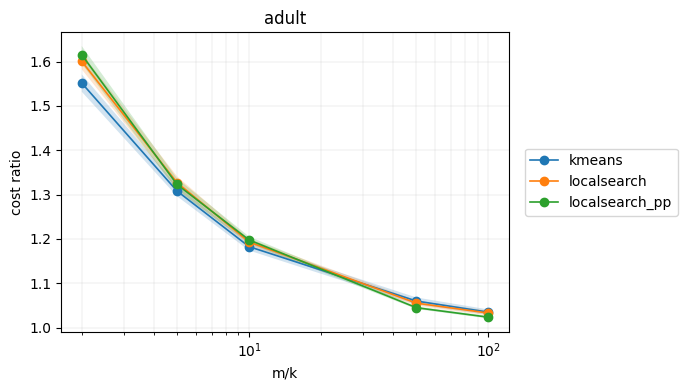


=== mnist: n=70000, d=784 ===


  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 0 ratio= 1.4038359778854983
logged: mnist localsearch k= 2 m= 4 trial= 0 ratio= 1.4066833759465571
logged: mnist localsearch_pp k= 2 m= 4 trial= 0 ratio= 1.4048911105025899
logged: mnist kmeans k= 2 m= 10 trial= 0 ratio= 1.2313832485668257
logged: mnist localsearch k= 2 m= 10 trial= 0 ratio= 1.1669379464578222
logged: mnist localsearch_pp k= 2 m= 10 trial= 0 ratio= 1.1654511423962592
logged: mnist kmeans k= 2 m= 20 trial= 0 ratio= 1.1108012985874485
logged: mnist localsearch k= 2 m= 20 trial= 0 ratio= 1.0999822874912968
logged: mnist localsearch_pp k= 2 m= 20 trial= 0 ratio= 1.0985807921181676
logged: mnist kmeans k= 2 m= 100 trial= 0 ratio= 1.018808535956185
logged: mnist localsearch k= 2 m= 100 trial= 0 ratio= 1.0364601191346214
logged: mnist localsearch_pp k= 2 m= 100 trial= 0 ratio= 1.036576757661039
logged: mnist kmeans k= 2 m= 200 trial= 0 ratio= 1.0129475032083848
logged: mnist localsearch k= 2 m= 200 trial= 0 ratio= 1.0085472214762008
logge

  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 1 ratio= 1.9601220660029246
logged: mnist localsearch k= 2 m= 4 trial= 1 ratio= 2.0063964503142495
logged: mnist localsearch_pp k= 2 m= 4 trial= 1 ratio= 2.0038902038574404
logged: mnist kmeans k= 2 m= 10 trial= 1 ratio= 1.3087510670642895
logged: mnist localsearch k= 2 m= 10 trial= 1 ratio= 1.2703187885539569
logged: mnist localsearch_pp k= 2 m= 10 trial= 1 ratio= 1.2687319974876485
logged: mnist kmeans k= 2 m= 20 trial= 1 ratio= 1.1277087872540685
logged: mnist localsearch k= 2 m= 20 trial= 1 ratio= 1.1373663554028965
logged: mnist localsearch_pp k= 2 m= 20 trial= 1 ratio= 1.1359456389747569
logged: mnist kmeans k= 2 m= 100 trial= 1 ratio= 1.0270693990749877
logged: mnist localsearch k= 2 m= 100 trial= 1 ratio= 1.0427019724764566
logged: mnist localsearch_pp k= 2 m= 100 trial= 1 ratio= 1.033645200693989
logged: mnist kmeans k= 2 m= 200 trial= 1 ratio= 1.0379360669720126
logged: mnist localsearch k= 2 m= 200 trial= 1 ratio= 1.008274214145864
logge

  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 2 ratio= 1.6262100707581264
logged: mnist localsearch k= 2 m= 4 trial= 2 ratio= 1.6230862410693176
logged: mnist localsearch_pp k= 2 m= 4 trial= 2 ratio= 1.6187525739026045
logged: mnist kmeans k= 2 m= 10 trial= 2 ratio= 1.2400623230666978
logged: mnist localsearch k= 2 m= 10 trial= 2 ratio= 1.250205849639422
logged: mnist localsearch_pp k= 2 m= 10 trial= 2 ratio= 1.246867779298412
logged: mnist kmeans k= 2 m= 20 trial= 2 ratio= 1.1400640306272696
logged: mnist localsearch k= 2 m= 20 trial= 2 ratio= 1.1394890018303683
logged: mnist localsearch_pp k= 2 m= 20 trial= 2 ratio= 1.1364465473081677
logged: mnist kmeans k= 2 m= 100 trial= 2 ratio= 1.0315133921226178
logged: mnist localsearch k= 2 m= 100 trial= 2 ratio= 1.0325534179994837
logged: mnist localsearch_pp k= 2 m= 100 trial= 2 ratio= 1.0302890448511217
logged: mnist kmeans k= 2 m= 200 trial= 2 ratio= 1.0137653258987882
logged: mnist localsearch k= 2 m= 200 trial= 2 ratio= 1.014462986277798
logged

  0%|          | 0/4 [00:00<?, ?it/s]

logged: mnist kmeans k= 2 m= 4 trial= 3 ratio= 1.575583908954682
logged: mnist localsearch k= 2 m= 4 trial= 3 ratio= 1.539109473003182
logged: mnist localsearch_pp k= 2 m= 4 trial= 3 ratio= 1.5392002559111606
logged: mnist kmeans k= 2 m= 10 trial= 3 ratio= 1.165470650873922
logged: mnist localsearch k= 2 m= 10 trial= 3 ratio= 1.1924632239864932
logged: mnist localsearch_pp k= 2 m= 10 trial= 3 ratio= 1.1925335602952676
logged: mnist kmeans k= 2 m= 20 trial= 3 ratio= 1.1204420638795318
logged: mnist localsearch k= 2 m= 20 trial= 3 ratio= 1.141285313259194
logged: mnist localsearch_pp k= 2 m= 20 trial= 3 ratio= 1.141352630887594
logged: mnist kmeans k= 2 m= 100 trial= 3 ratio= 1.0315074256999404
logged: mnist localsearch k= 2 m= 100 trial= 3 ratio= 1.0423115751720025
logged: mnist localsearch_pp k= 2 m= 100 trial= 3 ratio= 1.039731944638947
logged: mnist kmeans k= 2 m= 200 trial= 3 ratio= 1.013231318220773
logged: mnist localsearch k= 2 m= 200 trial= 3 ratio= 1.0152532437504116
logged: mn

KeyboardInterrupt: 

In [ ]:
# ----- grid -----
k_list = [2, 5, 10, 50, 100]
m_mults = [2, 5, 10, 50, 100]     # m = mult * k
trials = list(range(10))          # 10 runs

# ----- algorithm knobs (changeable at the end) -----
algo_params = {
    "localsearch": {
        "iters": 30,
        "eval_n": 20000,
        "try_centers": "all"      # or 10 for speed
    },
    "localsearch_pp": {
        "extra_rounds": 50,       # theory-ish knob; tune later
        "eval_n": 20000,
        "try_centers": "all"      # or 10 for speed
    }
}

lloyd_iters = 10  # keep as-is

# ----- load full datasets -----
print("Loading Adult...")
X_adult = load_adult_full()
print("Adult:", X_adult.shape)

print("Loading MNIST...")
X_mnist = load_mnist_full(center=True)
print("MNIST:", X_mnist.shape)

print("Loading Covertype...")
X_cov = load_covtype_full(scale=True)
print("Covertype:", X_cov.shape)

# ----- run dataset-by-dataset (partial plots after each dataset) -----
for name, X in [("adult", X_adult), ("mnist", X_mnist), ("covtype", X_cov)]:
    run_full_grid_for_dataset(name, X, k_list, m_mults, trials, algo_params, lloyd_iters=lloyd_iters)
    plot_dataset_m_over_k(RUNS_CSV, name)


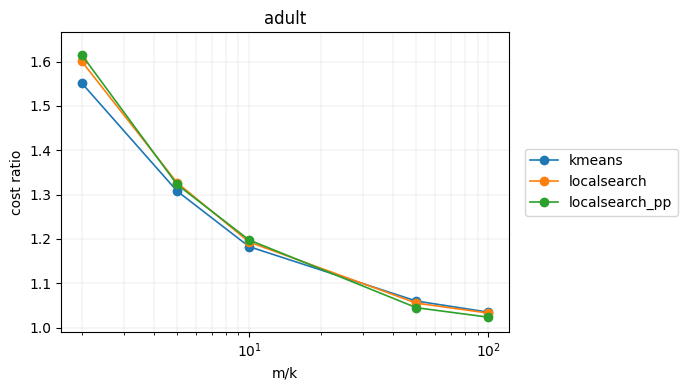

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# <-- change if needed
RUNS_CSV = "/content/drive/MyDrive/coreset_experiments/runs_fullgrid.csv"
DATASET = "adult"

df = pd.read_csv(RUNS_CSV)
df = df[df["dataset"] == DATASET].copy()
assert not df.empty, f"No rows found for dataset='{DATASET}' in {RUNS_CSV}"

# Aggregate across all k and trials for each algorithm and m/k
agg = df.groupby(["algorithm", "m_over_k"], as_index=False)["ratio"].agg(["mean", "std", "count"])
agg.columns = ["algorithm", "m_over_k", "mean", "std", "count"]
agg["sem"] = agg["std"] / np.sqrt(np.maximum(1, agg["count"]))

alg_order = ["kmeans", "localsearch", "localsearch_pp"]

plt.figure(figsize=(7,4))
for alg in alg_order:
    a = agg[agg["algorithm"] == alg].sort_values("m_over_k")
    if a.empty:
        continue
    plt.plot(a["m_over_k"], a["mean"], marker="o", linewidth=1.2, label=alg)
    plt.fill_between(a["m_over_k"], a["mean"]-a["sem"], a["mean"]+a["sem"], alpha=0.0)

plt.xscale("log")
plt.xlabel("m/k")
plt.ylabel("cost ratio")
plt.title("adult")
plt.grid(True, which="both", linewidth=0.3, alpha=0.5)
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()
